

GSOC'20 **Optional Task** for Deep Learning Algorithms for Muon Momentum Estimation in the CMS Trigger System

by Shubham Shaswat

Email: shaswat.cpp@gmail.com

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import tensorflow.keras as K
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd



TensorFlow 2.x selected.


In [0]:
#enable xla 
tf.config.optimizer.set_jit(True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#path and filename of data 
path = 'drive/My Drive/Colab Data/cern'
filename = 'histos_tba.20.npz'

In [0]:
import os
os.listdir(path)

['histos_tba.20.npz']

In [0]:
#loading the data
data = np.load(os.path.join(path,filename))
lst = data.files
print(lst)

['variables', 'parameters']


In [0]:
#shape of the data
print(data['variables'].shape)

(3272341, 87)


In [0]:
#load data features for CSC

phi = data['variables'][:,0:5]
theta = data['variables'][:,12:17]
bending_angle = data['variables'][:,24:29]
ring = data['variables'][:,48:53]
hit = data['variables'][:,60:65]
mask = data['variables'][:,72:77]



In [0]:
#contenate to make single array
train_data = np.concatenate((phi,theta,bending_angle,ring,hit,mask),axis=1)

In [0]:
#load transvere momentum
pt=np.abs(1/(data['parameters'][:,0]))


In [0]:
#replace the nan with 0
mask_ = np.isnan(train_data)
train_data = np.where(mask_,0,train_data)

In [0]:
#calucate max and min of the x_train along the colums
max_arr = np.max(train_data,axis=0)
min_arr = np.min(train_data,axis=0)


In [0]:
#normalise the trainig data
train_data = (train_data-min_arr)/(max_arr - min_arr)

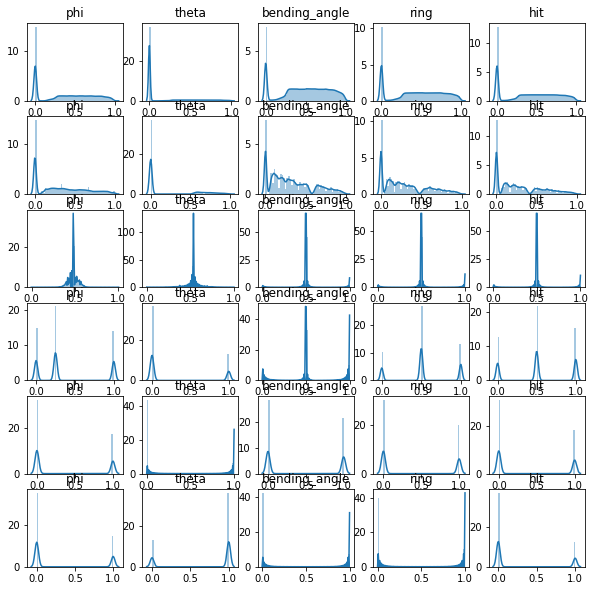

In [0]:
#distribution plots for each features after normalisation
import seaborn as sns
fig = plt.figure(figsize=(10,10))
labels = ['phi','theta','bending_angle','ring','hit','mask']
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.title(labels[i%5])
  sns.distplot(train_data[:,i])

In [0]:
#load tanseverse momentume into 4 categories

pt[np.where(pt < 10)] = 0
pt[np.where((pt >= 10 )& (pt < 30))] = 1
pt[np.where((pt < 100 )& (pt >= 30))] = 2
pt[np.where(pt >= 100 )] =3
 

In [0]:
#defina a function to free mem

del data
del phi
del theta
del bending_angle
del ring
del hit
del max_arr
del min_arr
del mask
del mask_


In [0]:
#calculate the sum of labels
h=[]
for i in range(4):
  h.append(len(pt[pt==i]))


<BarContainer object of 4 artists>

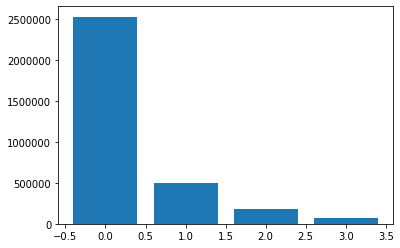

In [0]:
#plot bar for tansverse momentum labels

plt.bar(np.arange(4),h)


In [0]:
lr = 0.01 #learning rate

#loss object and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)

#define loss and accuracy metrics for both train and val data

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [0]:
#defina a train step
@tf.function
def train_step(x, A,y):
  with tf.GradientTape() as tape:
    
    predictions = model(x,A, training=True)
    loss = loss_object(y, predictions)


  gradients = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)



In [0]:
#define a test step
@tf.function
def test_step(x,A, y):
  
    
  predictions = model(x, A,training=False)
  t_loss = loss_object(y, predictions)


  test_loss(t_loss)
  test_accuracy(y, predictions)



In [0]:
import time


#function to train the model
def train(train_dataset,test_dataset,EPOCHS=2):

  acc_plot=[]
  loss_plot=[]
  t_acc=[]
  t_loss=[]

  for epoch in range(EPOCHS):

    #start time
    t0 = time.time()



    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    

    for x,A,y in train_dataset:
     train_step(x,A,y)
    

    for x,A,y in test_dataset:
      test_step(x,A, y)
    

    acc_plot.append(train_accuracy.result()*100)
    loss_plot.append(train_loss.result())
    
   
    t_acc.append(test_accuracy.result()*100)
    t_loss.append(test_loss.result())
    

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, Time {:.4f}  '
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100,
                          time.time()-t0
                          ))
    
  return acc_plot,t_acc,loss_plot,t_loss


In [0]:

from tensorflow.keras import Model

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout,MaxPooling2D,GRUCell,RNN,Layer


"""
The code is copied from the below mentionde URL
credits = https://github.com/SeongokRyu/Graph-neural-networks/blob/master/tutorials/ggnn.ipynb
The code is modified to be comaptible with TF2.0 
"""

#buidling a MPNN Model modeified for binary classification for the jet data


"""
  Parameters:
  -----------------------
  num_nodes : the number of nodes graph have
  input_dim : the nodes features dimension
  output_dim : the output dimension of the nodes
  -----------------------

"""

class MPNN(Model):

  def __init__(self,num_nodes,input_dim,output_dim):
    super(MPNN,self).__init__()

    self.num_nodes = num_nodes
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.dense1 = Dense(output_dim)
    self.gru_cell1 = GRUCell(output_dim) #GRU cell
    self.rnn = RNN(self.gru_cell1)
    self.dense2 = Dense(num_nodes,activation='relu') #Dense layer tp aggregate outputs of the all the nodes
    self.dense3 = Dense(4,activation='softmax') #Dense layer for classification
    

  def call(self,X,A):

    X = self.dense1(X)
    _m = tf.matmul(A,X)

    X_total=[]
    for i in range(self.num_nodes):
      mi = tf.expand_dims(_m[:,i,:],1)
      hi = X[:,i,:]
      _h = self.rnn(mi,initial_state=hi)
      X_total.append(tf.expand_dims(_h,1))

    out =tf.concat(X_total,axis=1)
    out = tf.squeeze(out,axis=-1)

    out = self.dense2(out) 
    out = self.dense3(out)
    
    return out



In [0]:
#reshape the train data
train_data1=np.reshape(train_data,[train_data.shape[0],5,6])

In [0]:
#split into train and test data,80% train data and 20% test data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_data1, pt, test_size=0.8, random_state=42)

In [0]:
#our Adjancey Matrix
_A=np.array([[1.,1.,0.,0.,0.],
            [0.,1.,1.,0.,0.],
            [0.,0.,1.,1.,0.],
            [0.,0.,0.,1.,1.],
            [0.,0.,0.,0.,1.]])

In [0]:
#define a map fn
#A is our Adjancey Matrix


def map_fn(x,y):
  #A = tf.constant(_A,dtype=np.float32)
  A = tf.ones((5,5))
  return x,A,y

In [0]:
#create input pipeline
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.map(map_fn)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_dataset = test_dataset.map(map_fn)
test_dataset = test_dataset.batch(BATCH_SIZE)



In [0]:
#call the model
model=MPNN(5,6,1)


In [0]:
#train the model
acc_,acc_t,loss_,loss_t=train(train_dataset,test_dataset,EPOCHS=5)

Epoch 1, Loss: 0.7153261303901672, Accuracy: 77.18696594238281, Test Loss: 0.710435688495636, Test Accuracy: 77.20233154296875, Time 205.6306  
Epoch 2, Loss: 0.7069321274757385, Accuracy: 77.19598388671875, Test Loss: 0.706824779510498, Test Accuracy: 77.20233154296875, Time 191.3250  
Epoch 3, Loss: 0.7007178664207458, Accuracy: 77.19598388671875, Test Loss: 0.6957578659057617, Test Accuracy: 77.20233154296875, Time 194.9861  
Epoch 4, Loss: 0.6954179406166077, Accuracy: 77.19598388671875, Test Loss: 0.6933169960975647, Test Accuracy: 77.20233154296875, Time 201.6832  
Epoch 5, Loss: 0.6948778033256531, Accuracy: 77.19598388671875, Test Loss: 0.6934382915496826, Test Accuracy: 77.20233154296875, Time 193.0614  


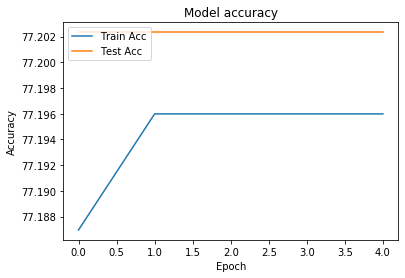

In [0]:
#plot accuracy

plt.plot(acc_)
plt.plot(acc_t)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Test Acc'], loc='upper left')


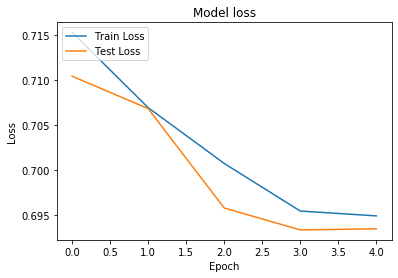

In [0]:
#plot loss
plt.plot(loss_)
plt.plot(loss_t) 
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')


NOTES:

The Message Passing Nueral Network Model that used in the Task-3 in Jet classification,the same model is applied here to classify the transverse momentum muon with fours class labels as 0-10 GeV, 10-30 GeV, 30-100 GeV and
&gt;100 GeV.

The accuracy and the loss plot is drawn above.

The only difference is that we used Directed graph with 5 nodes and each node with 6 features representing *'phi', 'theta', 'bending_angle', 'ring', 'hit', & 'mask'*

The Graph topology used is shown below

In [0]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from( [('1', '2'), ('2', '3'),('3','4'), ('4', '5')])

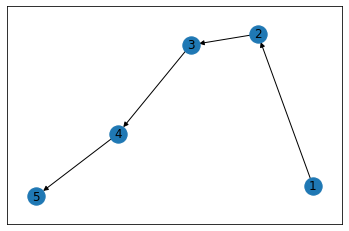

In [0]:
nx.draw_networkx(G)


Since,Loss and Accuracy is not look like a much improvement over the other classification model we have been used till now.

The followings points are for future work to improve model:


1.  Choosing a better Adjancey Matrix than the one we used.We could have a learnable adjancey matric A based on the [paper Neural Message Passing for Jet Physics](https://dl4physicalsciences.github.io/files/nips_dlps_2017_29.pdf)

2.  Adding more layer of MPNN could improve model performance

3. Handling the imbalanced data with suitable methods and metrics evaluations

4. Modifying features for the nodes and edges could be checked for any improvement

